# Background

Data was purchased from the Handle.net administrators for prefix 2374.UC,
which we use in connection with the DRC.


In [1]:
import pandas as pd


file = "~/onedrive/digital-collections/handle/handle-data-agent.tsv"
df = pd.read_csv(file, sep="\t")



Cleaning data:

In [2]:
# change timestamps to date only
date = df['timestamp'].str.split("\t", expand=True)[0]
df['timestamp'] = date.astype("datetime64")

plot = df["timestamp"].groupby([
    df["timestamp"].dt.year,
    df["timestamp"].dt.month,
]).count().plot(kind="bar")
print(plot)


AxesSubplot(0.125,0.11;0.775x0.77)


Filter out crawler user agents - found [here](https://github.com/monperrus/crawler-user-agents)

/Users/vanmiljf/development/handle-log-notebook/venv/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


AxesSubplot(0.125,0.125;0.775x0.755)


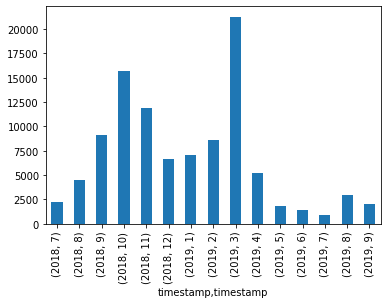

In [3]:
import json


with open("crawler-user-agents.json") as json_file:
    crawler_patterns = [crawler["pattern"] for crawler in json.load(json_file)]
    # Add additional values
    crawler_patterns += [
       "montastic-monitor",
       "tigerbot",
       "RyteBot",
       "Altmetribot",
    ]
    for pattern in crawler_patterns:
        filter = df['agent'].str.contains(pattern, na=False)
        df = df[~filter]
        
plot = df["timestamp"].groupby([
    df["timestamp"].dt.year,
    df["timestamp"].dt.month,
]).count().plot(kind="bar")
print(plot)


In [11]:
import requests
import requests_cache
from bs4 import BeautifulSoup


series = []
host = []
requests_cache.install_cache("handle_cache")
for handle in df["handle"]:
    r = requests.get(
        "https://drc.libraries.uc.edu/oai/" +
        "request?verb=GetRecord" +
        "&metadataPrefix=mets" +
        f"&identifier=oai:drc.libraries.uc.edu:{handle}"
    )

    if r.status_code != 200:
        series.append(f"error - {r.status_code}")
        host.append(f"error - {r.status_code}")
        continue

    soup = BeautifulSoup(r.content, "lxml-xml")
    error = soup.find("error")
    if error:
        series.append(error.text)
        host.append(error.text)
        continue

    soup_series =  soup.find_all("mods:relatedItem", {"type": "series"})
    if soup_series:
        series.append("|".join([s.text for s in soup_series]))
    else:
        series.append("")

    soup_hosts =  soup.find_all("mods:relatedItem", {"type": "host"})
    if soup_hosts:
        host.append("|".join([h.text for h in soup_hosts]))
    else:
        host.append("")

df['series'] = series
df['host'] = host


KeyboardInterrupt: 

In [ ]:
df.to_csv("out.csv")
